In [152]:
# Import library

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima.model import ARIMA 
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings('ignore')
import pylab
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [153]:
cinema = pd.read_csv("cinema.csv")
cinema["date"] = pd.to_datetime(cinema["date"])
cinema_df = cinema[["date", "tickets_sold"]]
cinema_final_df = cinema.groupby("date")["tickets_sold"].sum().to_frame()
cinema_final_df = cinema_final_df.loc['2018-04-01':'2018-10-31']

In [154]:
full_date_range = pd.date_range(start=cinema_final_df.index.min(), end=cinema_final_df.index.max(), freq='D')

# Step 3: Identify missing dates by comparing the full range with your index
missing_dates = full_date_range.difference(cinema_final_df.index)

cinema_final_df.index = pd.to_datetime(cinema_final_df.index)

# Convert missing dates to a DateTimeIndex
missing_dates = pd.to_datetime(missing_dates)

# Step 1: Reindex the DataFrame to include the missing dates
cinema_final_df = cinema_final_df.reindex(cinema_final_df.index.union(missing_dates))

# Step 2: Calculate the average of 'tickets_sold' column
average_tickets_sold = cinema_final_df['tickets_sold'].mean()

# Step 3: Fill missing values with the average
cinema_final_df['tickets_sold'].fillna(average_tickets_sold, inplace=True)

Text(0, 0.5, 'Tickets Sold')

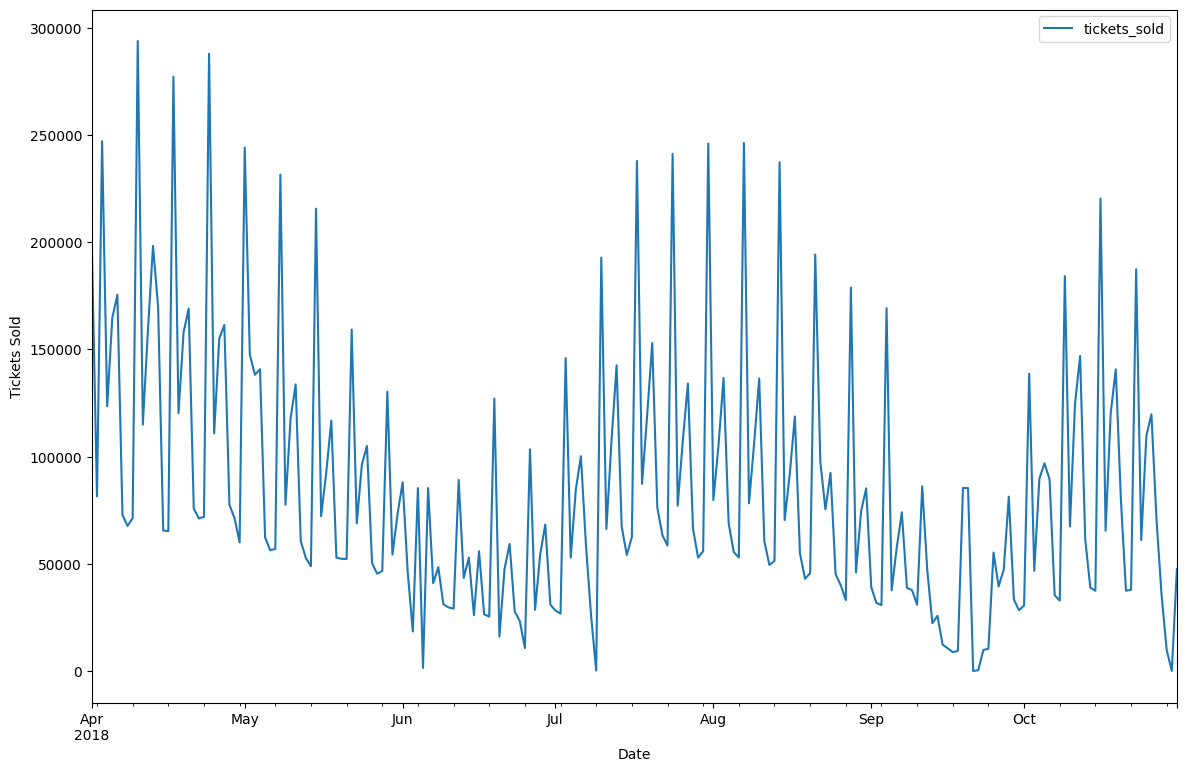

In [155]:
cinema_final_df.plot()
plt.xlabel('Date')
plt.ylabel('Tickets Sold')

# B. Time Series Decomposition

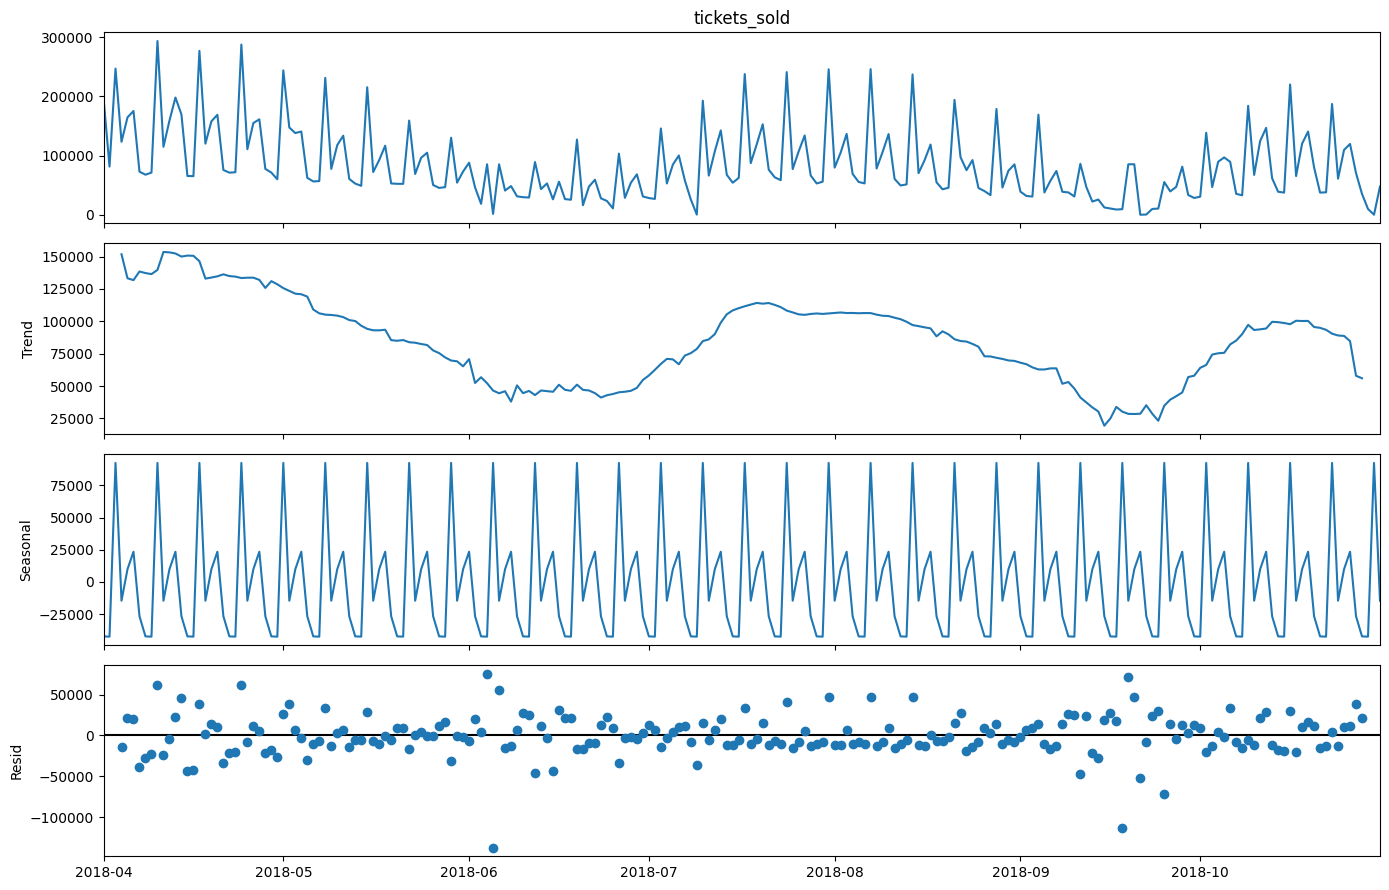

In [156]:
pylab.rcParams['figure.figsize'] = (14, 9)
res = seasonal_decompose(cinema_final_df['tickets_sold'], model='additive')
ax=res.plot()
plt.show()

# C. Stationarity

## C.1 - Without Differencing

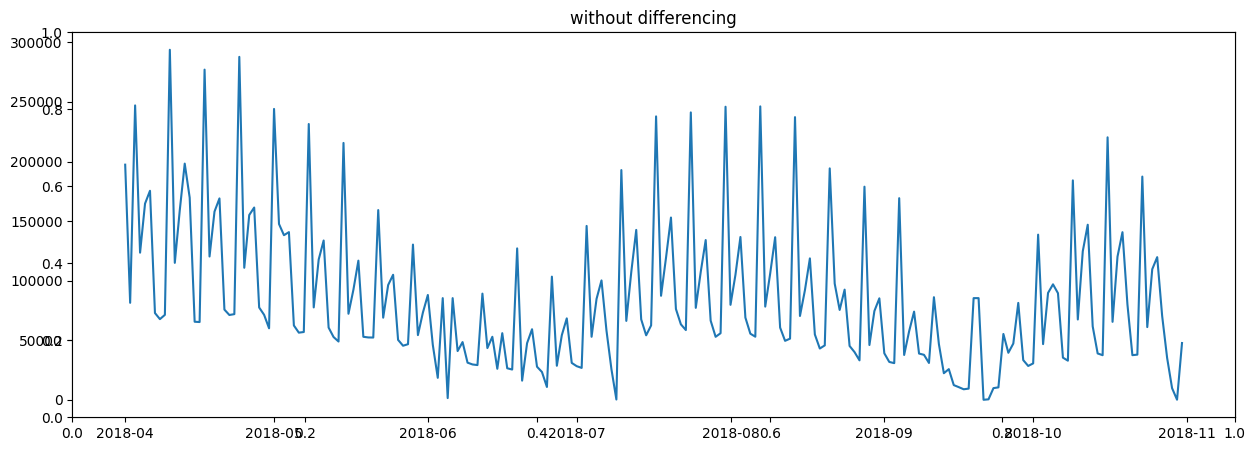

In [157]:
# Plot without differencing

fig, ax = plt.subplots(figsize=(15,5))
ax1 = fig.add_subplot(111)
ax1.set_title('without differencing')
ax1.plot(cinema_final_df['tickets_sold'])

## C.2 - First-Order Differencing

In [158]:
# Create a function to check stationarity

def check_stationarity(series):
    # Copied from https://machinelearningmastery.com/time-series-data-stationary-python/

    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [159]:
# Check stationarity of the dataset

check_stationarity(cinema_final_df['tickets_sold'])

ADF Statistic: -2.217475
p-value: 0.199964
Critical Values:
	1%: -3.463
	5%: -2.876
	10%: -2.574
Non-stationary


In [160]:
# Perform first-order differencing

diff1 = cinema_final_df['tickets_sold'].diff()
diff1

2018-04-01         NaN
2018-04-02   -115945.0
2018-04-03    165692.0
2018-04-04   -123603.0
2018-04-05     41169.0
                ...   
2018-10-27    -49379.0
2018-10-28    -35165.0
2018-10-29    -25440.0
2018-10-30     -9669.0
2018-10-31     47575.0
Freq: D, Name: tickets_sold, Length: 214, dtype: float64

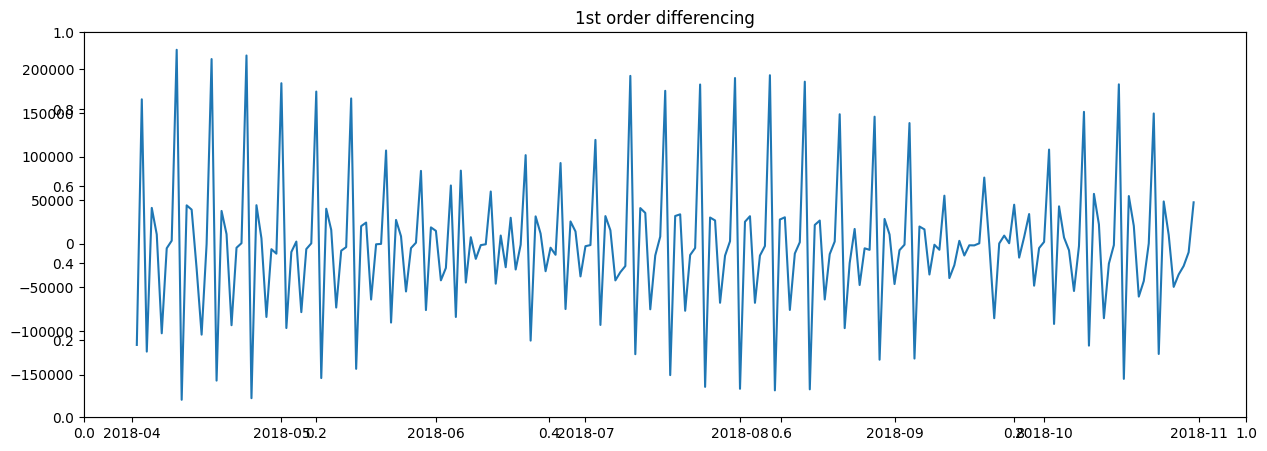

In [161]:
# Plot the result after first-order differencing

fig, ax = plt.subplots(figsize=(15,5))
ax1 = fig.add_subplot(111)
ax1.set_title('1st order differencing')
ax1.plot(diff1)

In [162]:
# Check stationarity after performing first-order differencing

print("1st order differencing")
check_stationarity(diff1.dropna())

1st order differencing
ADF Statistic: -3.280797
p-value: 0.015759
Critical Values:
	1%: -3.463
	5%: -2.876
	10%: -2.574
Stationary


# D. ACF & PACF

To determine the value of `p` and `q`, you can follow the following recommendation :

**For Moving Average (MA) :**
* `MA(q)`.
* The value of `q` is taken from cut off of the ACF plot.

**For Auto Regressive (AR) :**
* `AR(p)`.
* The value of `p` is taken from cut off of the PACF plot.

**For Auto Regressive Moving Average (ARMA) :**
* `ARMA(p, q)`
* The value of cut off from ACF plot & PACF plot can be used as `p` or `q`.

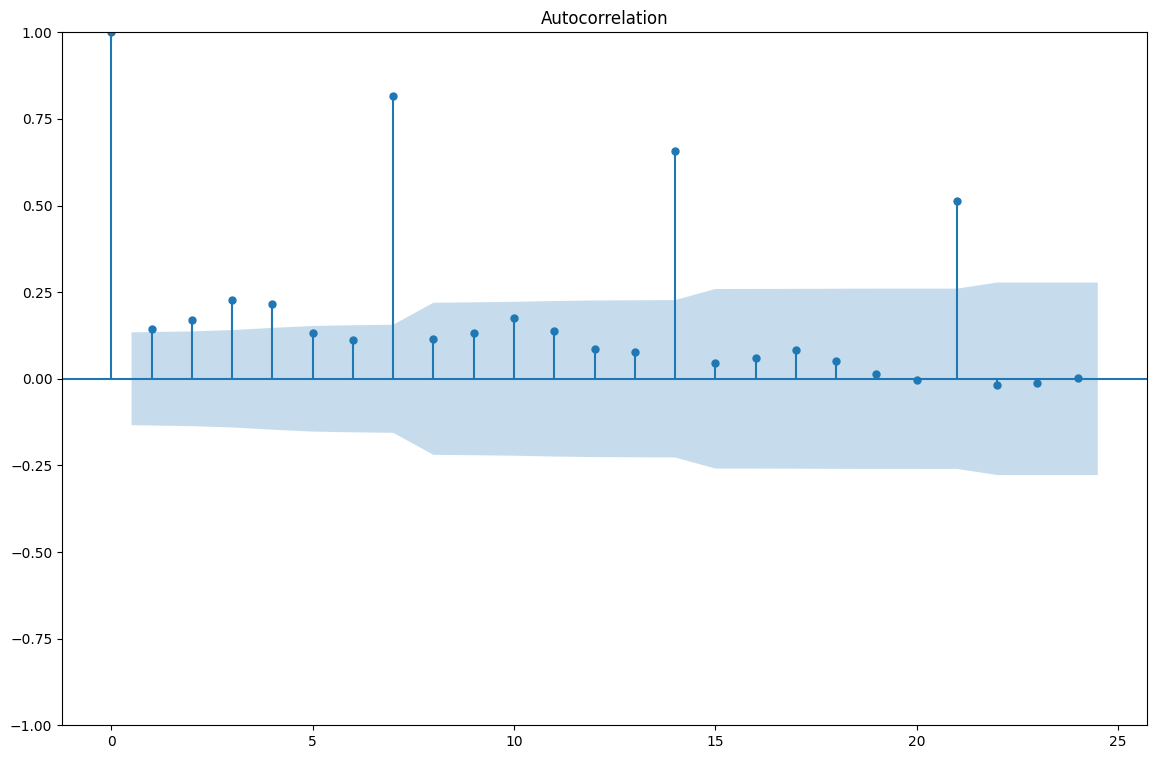

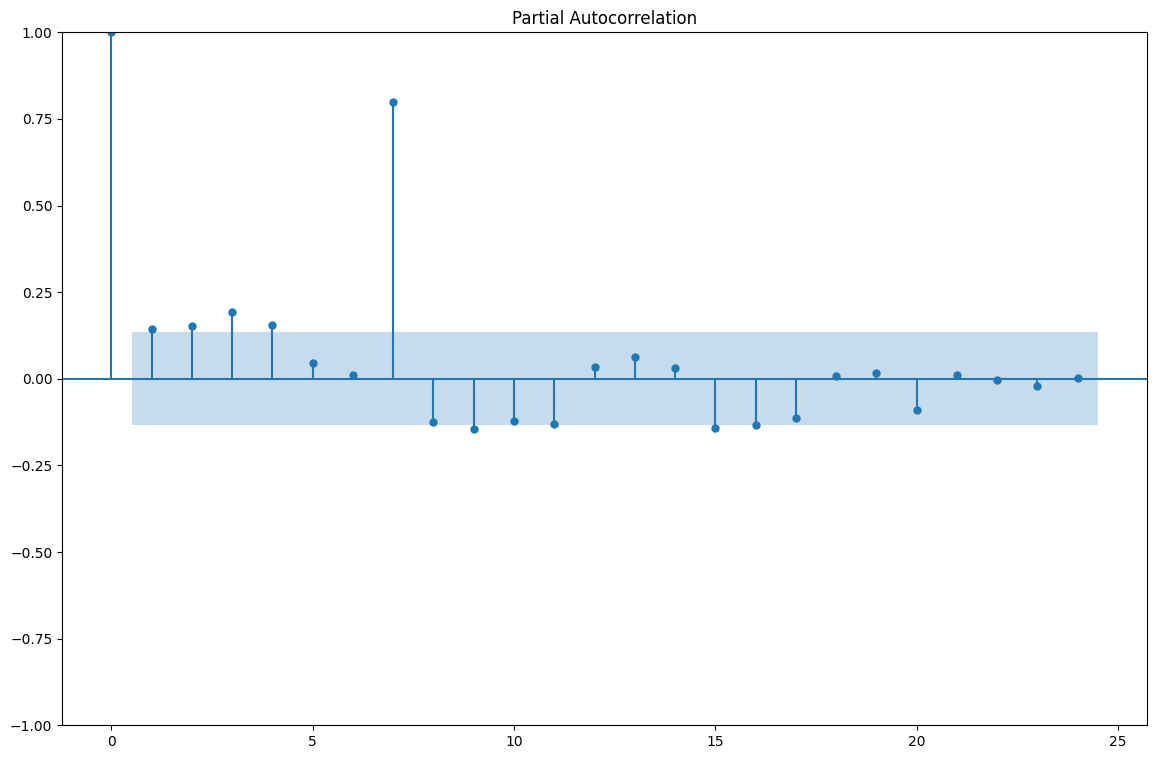

In [163]:
plot_acf(cinema_final_df["tickets_sold"])
plot_pacf(cinema_final_df["tickets_sold"])
plt.show()

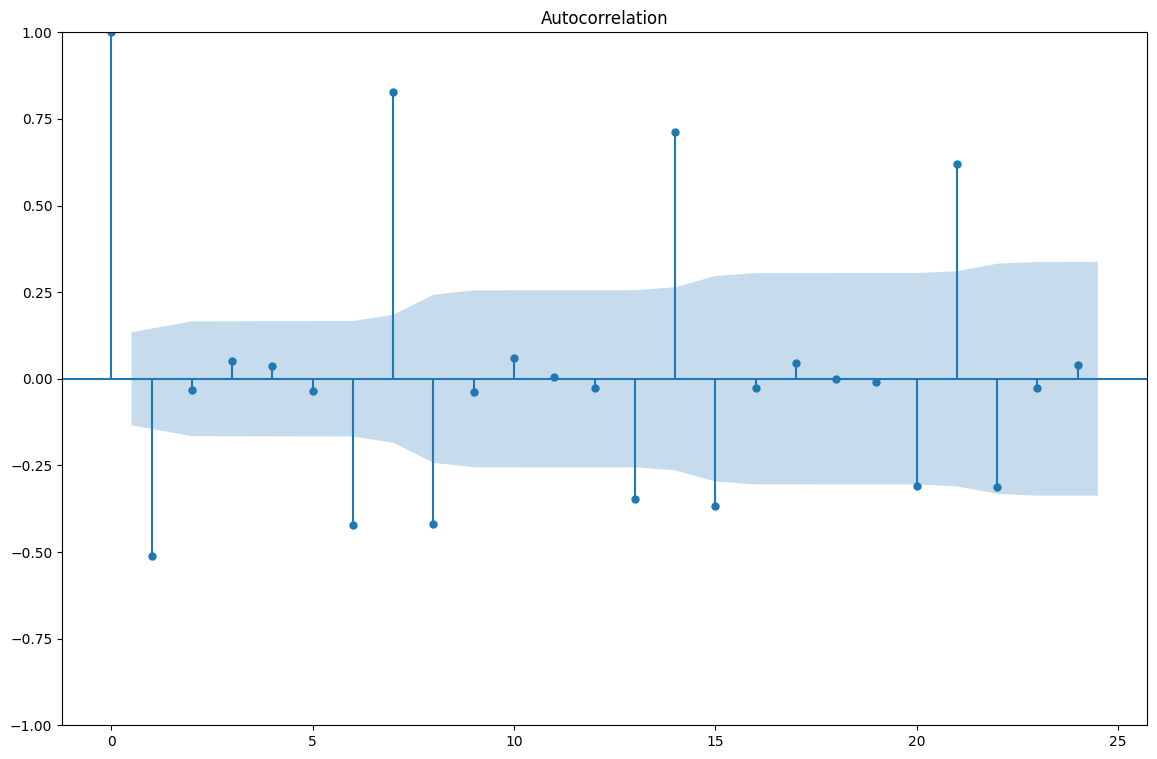

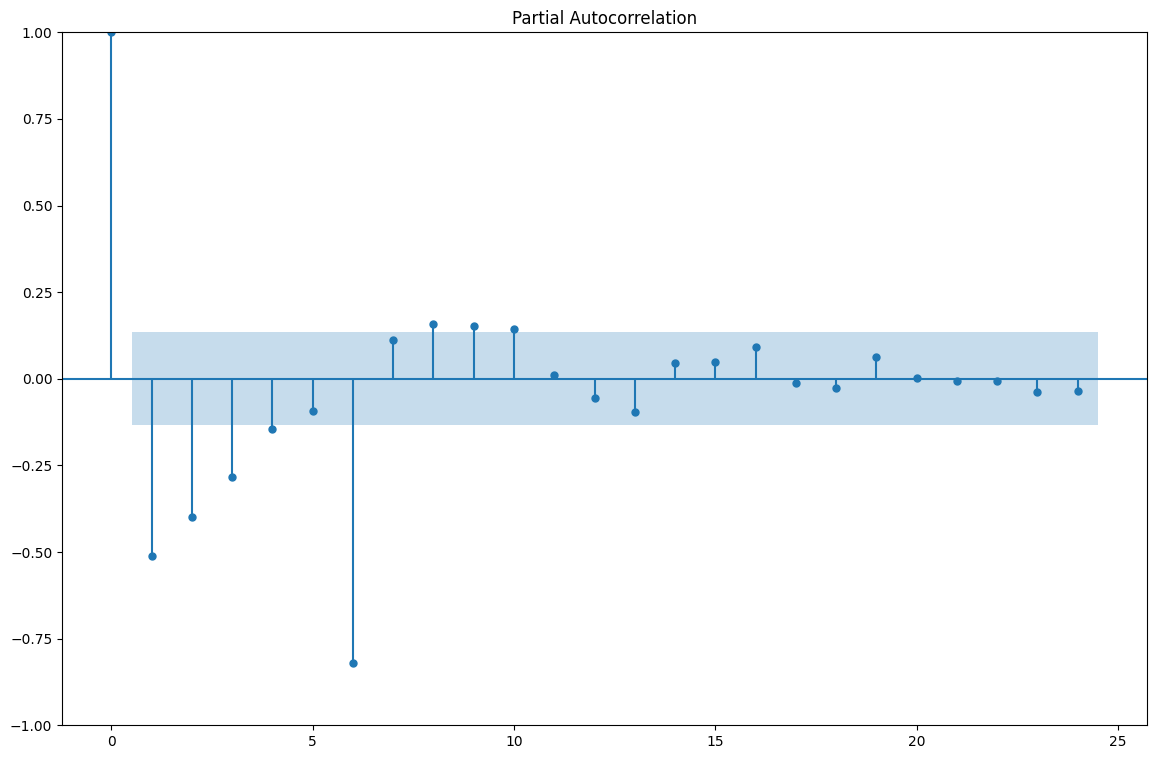

In [164]:
# Plot ACF & PACF after performing first-order differencing

plot_acf(cinema_final_df["tickets_sold"].diff().dropna())
plot_pacf(cinema_final_df["tickets_sold"].diff().dropna())
plt.show()

# E. ARIMA

In [165]:
# Create a function to find best model

def find_best_model(data, num_p, num_d, num_q):
  df = pd.DataFrame() #We make a pandas dataframe to ease our work, you can use any way that makes you comfortable and work easly
  pdq = [[],[],[]] #This list for storing the combinations of p and q
  aic = [] # This list for storing aic value
  for p in range(num_p + 1): #plus one is to make the range up to num_p since python range only ranging from 0 to N-1
    for d in range(num_d + 1):
      for q in range(num_q + 1):
        # #if p!=0 and q!=0: #this logic will avoid (0,0) value which is not correct
        try: #Using exception to avoid the error while training the model with certain p and q value
          model = ARIMA(data, order=(p, d, q))
          result = model.fit()
          pdq[0].append(p)
          pdq[1].append(d)
          pdq[2].append(q)
          aic.append(result.aic)
        except:
          pass #If there is an error caused by the calculation, it will be skipped to the next iteration

  df['p'] = pdq[0]
  df['d'] = pdq[1]
  df['q'] = pdq[2]
  df['AIC'] = aic

  df.sort_values('AIC', inplace=True)

  return df.p.iloc[0], df.d.iloc[0], df.q.iloc[0], df.AIC.iloc[0], df

In [166]:
# Find best model of ARIMA with combinations of p=4, d=4, q=4

find_best_model(cinema_final_df["tickets_sold"], 4, 4, 4)

(3,
 1,
 4,
 5218.981460877533,
      p  d  q          AIC
 84   3  1  4  5218.981461
 109  4  1  4  5219.305336
 59   2  1  4  5222.574011
 114  4  2  4  5228.170021
 113  4  2  3  5230.189224
 ..  .. .. ..          ...
 21   0  4  1  5834.792602
 15   0  3  0  5850.528170
 45   1  4  0  5878.357543
 20   0  4  0  6082.666682
 0    0  0  0  6264.620927
 
 [125 rows x 4 columns])

In [167]:
model_arima_414 = ARIMA(cinema_final_df["tickets_sold"], order=(3, 1, 4))
result_model_arima_414 = model_arima_414.fit()

print('The AIC is ', result_model_arima_414.aic)

The AIC is  5218.981460877533


In [168]:
# Predict next 30 days

len_dataset = cinema_final_df.shape[0]
len_predict = len_dataset + 90

new_pred = result_model_arima_414.predict(len_dataset, len_predict)
new_pred = pd.DataFrame(new_pred)
new_pred.columns=['tickets_sold']
all_dataset_with_pred = pd.concat([cinema_final_df, new_pred], axis=0)

In [169]:
# Original dataset

cinema_final_df.tail(5)

,tickets_sold
2018-10-27,70343.0
2018-10-28,35178.0
2018-10-29,9738.0
2018-10-30,69.0
2018-10-31,47644.0


In [170]:
# Prediction of next 12 months

new_pred

,tickets_sold
2018-11-01,98360.952393
2018-11-02,91673.328031
2018-11-03,39038.873749
2018-11-04,13800.175183
2018-11-05,37226.760814
...,...
2019-01-26,22593.214809
2019-01-27,22593.214812
2019-01-28,22593.214816
2019-01-29,22593.214811


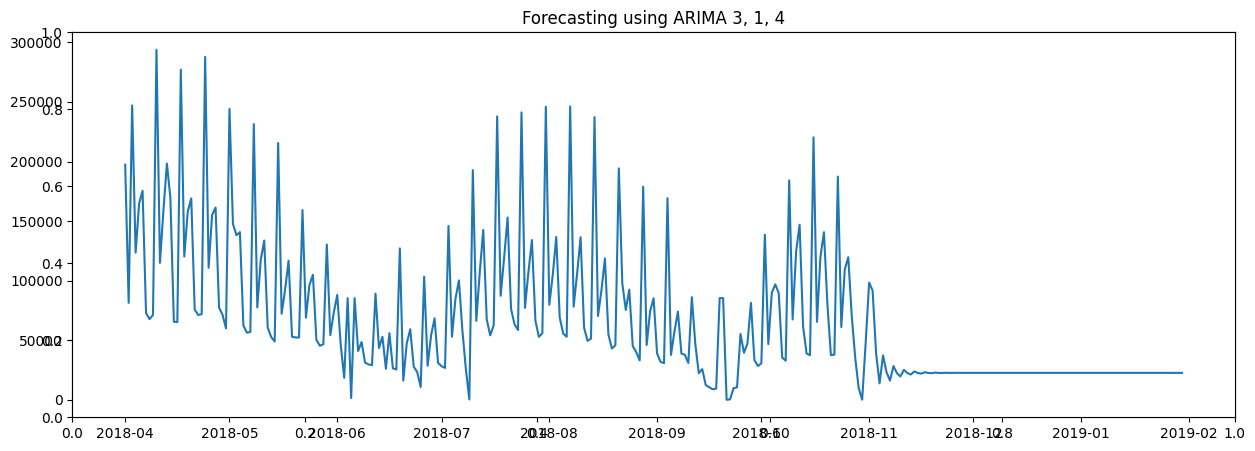

In [171]:
# Plot all dataset including prediction

fig, ax = plt.subplots(figsize=(15,5))
ax1 = fig.add_subplot(111)
ax1.set_title('Forecasting using ARIMA 3, 1, 4')
ax1.plot(all_dataset_with_pred)

In [172]:
# Splitting dataset

train = cinema_final_df[:150]
test = cinema_final_df[150:]

print('Train size : ', train.shape)
print('Test size : ', test.shape)

Train size :  (150, 1)
Test size :  (64, 1)


In [173]:
# Stationarity check

check_stationarity(train['tickets_sold'])

ADF Statistic: -2.767820
p-value: 0.063019
Critical Values:
	1%: -3.479
	5%: -2.883
	10%: -2.578
Non-stationary


In [174]:
# First-order differencing

check_stationarity(train['tickets_sold'].diff().dropna())

ADF Statistic: -3.561311
p-value: 0.006545
Critical Values:
	1%: -3.479
	5%: -2.883
	10%: -2.578
Stationary


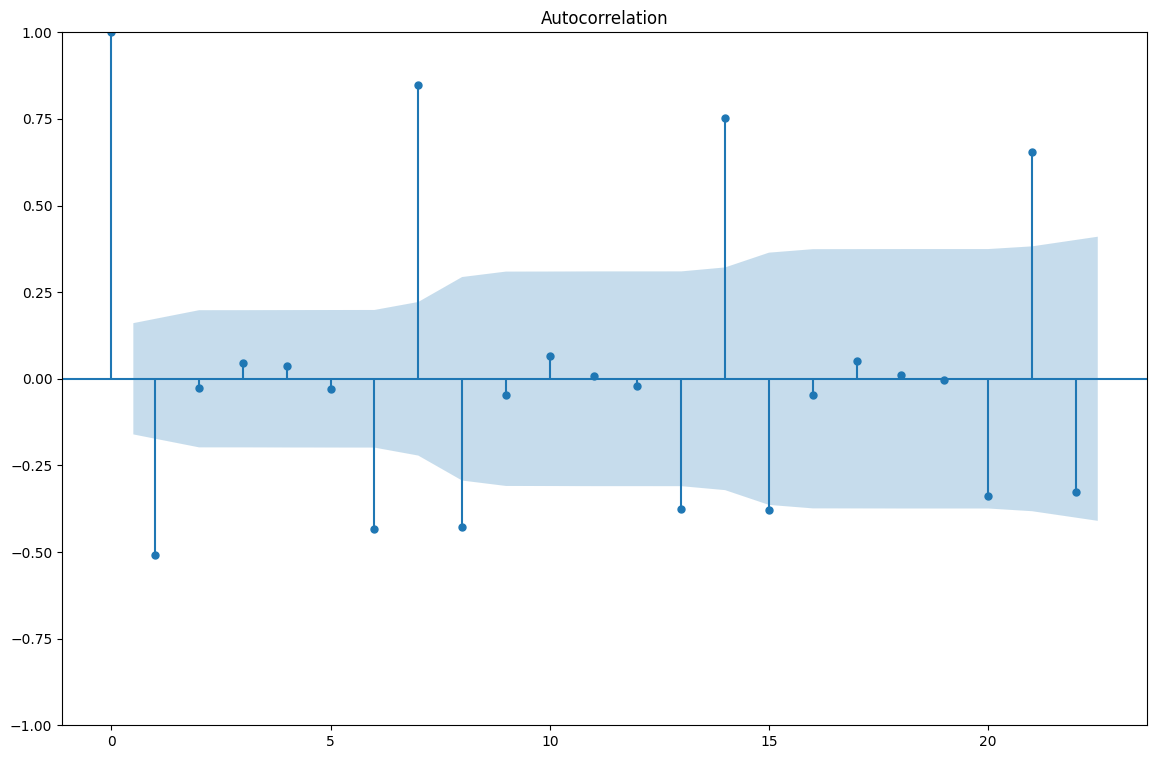

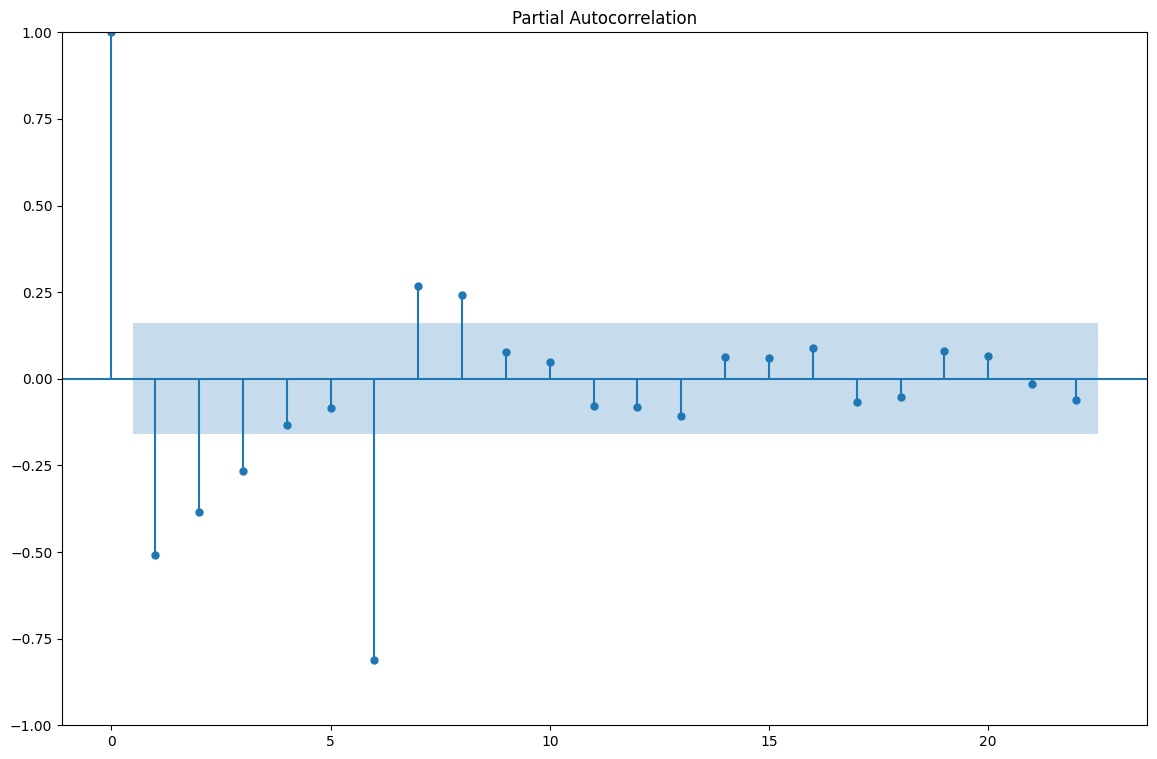

In [175]:
# Check plot ACF & PACF

plot_acf(train['tickets_sold'].diff().dropna())
plot_pacf(train['tickets_sold'].diff().dropna())
plt.show()

In [176]:
# Train with p=3, d=1, q=1

arima = ARIMA(train, order=(3, 1, 1))
mod_train = arima.fit()
mod_train.aic

3702.390186760097

# F. SARIMA

In [180]:
# Splitting dataset

train = cinema_final_df[:150]
test = cinema_final_df[150:]

print('Train size : ', train.shape)
print('Test size : ', test.shape)

Train size :  (150, 1)
Test size :  (64, 1)


In [181]:
# Display train-set

train

,tickets_sold
2018-04-01,197341.0
2018-04-02,81396.0
2018-04-03,247088.0
2018-04-04,123485.0
2018-04-05,164654.0
...,...
2018-08-24,92444.0
2018-08-25,45191.0
2018-08-26,40022.0
2018-08-27,33097.0


In [182]:
# Display train-set

test

,tickets_sold
2018-08-29,45969.0
2018-08-30,74497.0
2018-08-31,85167.0
2018-09-01,39044.0
2018-09-02,31772.0
...,...
2018-10-27,70343.0
2018-10-28,35178.0
2018-10-29,9738.0
2018-10-30,69.0


In [183]:
sar=SARIMAX(train['tickets_sold'], order=(3, 1, 1),seasonal_order=(3, 1, 1, 31)).fit()
sar.summary()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00437D+01    |proj g|=  2.00858D-01

At iterate    5    f=  9.94892D+00    |proj g|=  3.37585D-02

At iterate   10    f=  9.94525D+00    |proj g|=  7.45702D-04

At iterate   15    f=  9.94512D+00    |proj g|=  1.99208D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     19     21      1     0     0   1.286D-05   9.945D+00
  F =   9.9451117918728986     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                       tickets_sold   No. Observations:                  150
Model:             SARIMAX(3, 1, 1)x(3, 1, 1, 31)   Log Likelihood               -1491.767
Date:                            Sun, 20 Oct 2024   AIC                           3001.534
Time:                                    19:59:18   BIC                           3026.470
Sample:                                04-01-2018   HQIC                          3011.658
                                     - 08-28-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1134      0.364     -0.311      0.756      -0.828       0.601
ar.L2         -0.1435      0.433     -0.331      0.740      -0.993       0.706
ar.L3         -0.0421      0.279     -0.151      0.880      -0.589       0.504
ma.L1         -0.7529      0.255     -2.953      0.003      -1.253      -0.253
ar.S.L31      -0.3824      6.457     -0.059      0.953     -13.039      12.274
ar.S.L62      -0.1830      4.161     -0.044      0.965      -8.338       7.972
ar.S.L93      -0.0390      1.862     -0.021      0.983      -3.689       3.610
ma.S.L31      -0.3164      6.626     -0.048      0.962     -13.303      12.670
sigma2       8.36e+09   3.49e-08    2.4e+17      0.000    8.36e+09    8.36e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.16   Jarque-Bera (JB):                19.40
Prob(Q):                              0.69   Prob(JB):                         0.00
Heteroskedasticity (H):               1.11   Skew:                             0.93
Prob(H) (two-sided):                  0.74   Kurtosis:                         3.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.32e+33. Standard errors may be unstable.
"""

In [184]:
# Predict test-set

## Predict test-set
sar_pred_test = sar.predict(start="2018-08-29", end="2018-10-31", dynamic=True)
sar_pred_test = pd.DataFrame(sar_pred_test)
sar_pred_test.columns = ['TicketsSold_Predict']

## Concate with actual test-set
act_vs_pred_sar=pd.concat([test, sar_pred_test], axis=1)
act_vs_pred_sar

,tickets_sold,TicketsSold_Predict
2018-08-29,45969.0,66344.796907
2018-08-30,74497.0,68766.063552
2018-08-31,85167.0,106523.409242
2018-09-01,39044.0,64336.088307
2018-09-02,31772.0,95482.156693
...,...,...
2018-10-27,70343.0,74994.295970
2018-10-28,35178.0,90261.018099
2018-10-29,9738.0,111166.822863
2018-10-30,69.0,68373.541122


In [185]:
print('MAE test  : ', mean_absolute_error(test, sar_pred_test))
print('RMSE test : ', np.sqrt(mean_squared_error(test, sar_pred_test)))

MAE test  :  53850.57032652538
RMSE test :  65064.756464996026
